In [277]:
import numpy as np
from numpy import ndarray
import time
from openvino.inference_engine import IECore,IENetwork
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import argparse
import sys

DIR_PATH = os.path.split(os.getcwd())[0]
video_file = os.path.join(DIR_PATH,"bin\\demo.mp4")

face_model = os.path.join(DIR_PATH,os.path.join('model\\intel\\face-detection-adas-binary-0001\\FP32-INT1\\face-detection-adas-binary-0001'))
landmark_model= os.path.join(DIR_PATH,os.path.join('model\\intel\\landmarks-regression-retail-0009\\FP32-INT8\\landmarks-regression-retail-0009'))

In [278]:
class InputFeeder:
    def __init__(self, input_type, input_file=None):
        '''
        input_type: str, The type of input. Can be 'video' for video file, 'image' for image file,
                    or 'cam' to use webcam feed.
        input_file: str, The file that contains the input image or video file. Leave empty for cam input_type.
        '''
        self.input_type=input_type
        if input_type=='video' or input_type=='image':
            self.input_file=input_file
    
    def load_data(self):
        if self.input_type=='video':
            self.cap=cv2.VideoCapture(self.input_file)
        elif self.input_type=='cam':
            self.cap=cv2.VideoCapture(0)
        else:
            self.cap=cv2.imread(self.input_file)

    def next_batch(self):
        '''
        Returns the next image from either a video file or webcam.
        If input_type is 'image', then it returns the same image.
        '''
        while True:
            for _ in range(10):
                _, frame=self.cap.read()
            yield frame


    def close(self):
        '''
        Closes the VideoCapture.
        '''
        if not self.input_type=='image':
            self.cap.release()

In [279]:
import pyautogui

class MouseController:
    def __init__(self, precision, speed):
        precision_dict={'high':100, 'low':1000, 'medium':500}
        speed_dict={'fast':1, 'slow':10, 'medium':5}

        self.precision=precision_dict[precision]
        self.speed=speed_dict[speed]

    def move(self, x, y):
        pyautogui.moveRel(x*self.precision, -1*y*self.precision, duration=self.speed)


In [280]:
class FaceDetection:
    '''
    Class for the Face Detection Model.
    '''
    def __init__(self, model_name, device='CPU', extensions=None):
        self.model_weights=model_name+'.bin'
        self.model_structure=model_name+'.xml'
        self.device=device
        self.extensions=extensions
        try:
            self.model=IENetwork(self.model_structure, self.model_weights)
        except Exception as e:
            raise ValueError("Could not Initialise the network. Have you enterred the correct model path?")

        self.input_name=next(iter(self.model.inputs))
        self.input_shape=self.model.inputs[self.input_name].shape
        self.output_name=next(iter(self.model.outputs))
        self.output_shape=self.model.outputs[self.output_name].shape
        
    def load_model(self):
        self.net = IECore().load_network(network = self.model, device_name = self.device,num_requests=1)

    def predict(self, image):
        self.preprocess_image  = self.preprocess_input(np.copy(image))
        self.net.start_async(request_id=0, inputs={self.input_name: self.preprocess_image})
        if self.net.requests[0].wait(-1) == 0:
            outputs = self.net.requests[0].outputs
            face_image = self.preprocess_output(outputs,image)
        return face_image

    def check_model(self):
        raise NotImplementedError

    def preprocess_input(self, image):
        image = cv2.resize(image, (self.input_shape[3], self.input_shape[2]))
        image = image.transpose((2,0,1))
        image = image.reshape(1, *image.shape)
        return image

    def preprocess_output(self, outputs,image):
        box = outputs[self.output_name][0][0][0]
        xmin = int(box[3] * image.shape[1])
        ymin = int(box[4] * image.shape[0])
        xmax = int(box[5] * image.shape[1])
        ymax = int(box[6] * image.shape[0])
        return image[ymin:ymax,xmin:xmax]

In [281]:
class LandmarkRegression:
    '''
    Class for the Landmark Regression Model.
    '''
    def __init__(self, model_name, device='CPU', extensions=None):
        self.model_weights=model_name+'.bin'
        self.model_structure=model_name+'.xml'
        self.device=device
        self.extensions=extensions
        try:
            self.model=IENetwork(self.model_structure, self.model_weights)
        except Exception as e:
            raise ValueError("Could not Initialise the network. Have you enterred the correct model path?")

        self.input_name=next(iter(self.model.inputs))
        self.input_shape=self.model.inputs[self.input_name].shape
        self.output_name=next(iter(self.model.outputs))
        self.output_shape=self.model.outputs[self.output_name].shape
        
    def load_model(self):
        self.net = IECore().load_network(network = self.model, device_name = self.device,num_requests=1)

    def predict(self, image):
        self.preprocess_image  = self.preprocess_input(np.copy(image))
        self.net.start_async(request_id=0, inputs={self.input_name: self.preprocess_image})
        if self.net.requests[0].wait(-1) == 0:
            outputs = self.net.requests[0].outputs
            image = self.preprocess_output(outputs,image)
        return image

    def check_model(self):
        raise NotImplementedError

    def preprocess_input(self, image):
        image = cv2.resize(image, (self.input_shape[3], self.input_shape[2]))
        image = image.transpose((2,0,1))
        image = image.reshape(1, *image.shape)
        return image

    def preprocess_output(self, outputs,image):
        outputs = outputs[self.output_name].squeeze()
        left_eye_xmin = int(outputs[0]*image.shape[1])
        left_eye_ymin = int(outputs[1]*image.shape[0])
        right_eye_xmin = int(outputs[2]*image.shape[1])
        right_eye_ymin = int(outputs[3]*image.shape[0])
        image[left_eye_ymin:left_eye_ymin+8,left_eye_xmin:left_eye_xmin+8]=(0,0,255)
        image[right_eye_ymin:right_eye_ymin+8,right_eye_xmin:right_eye_xmin+8]=(0,0,255)
        return image

In [282]:
input_feder = InputFeeder('video',video_file)
input_feder.load_data()
face_detection= FaceDetection(face_model)
face_detection.load_model()
landmark_regression= LandmarkRegression(landmark_model)
landmark_regression.load_model()

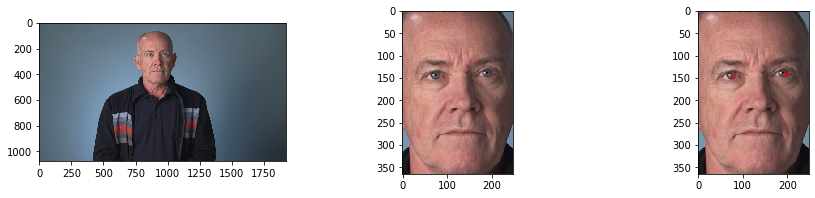

In [283]:
image = next(iter(input_feder.next_batch()))
face_image = face_detection.predict(image)
landmark_face_image = landmark_regression.predict(np.copy(face_image))
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(face_image,cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(landmark_face_image,cv2.COLOR_BGR2RGB))